In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBRegressor as XGB
from sklearn.metrics import mean_absolute_error as mae
SEED=42

from src.styles import *
set_styles()

# Client

In [3]:
df_client = pd.read_csv('data/client.csv')
df_client

,product_type,county,eic_count,installed_capacity,is_business,date,data_block_id
0,1,0,108,952.89,0,2021-09-01,2
1,2,0,17,166.40,0,2021-09-01,2
2,3,0,688,7207.88,0,2021-09-01,2
3,0,0,5,400.00,1,2021-09-01,2
4,1,0,43,1411.00,1,2021-09-01,2
...,...,...,...,...,...,...,...
41914,1,15,51,415.60,0,2023-05-29,637
41915,3,15,161,2035.75,0,2023-05-29,637
41916,0,15,15,620.00,1,2023-05-29,637
41917,1,15,20,624.50,1,2023-05-29,637


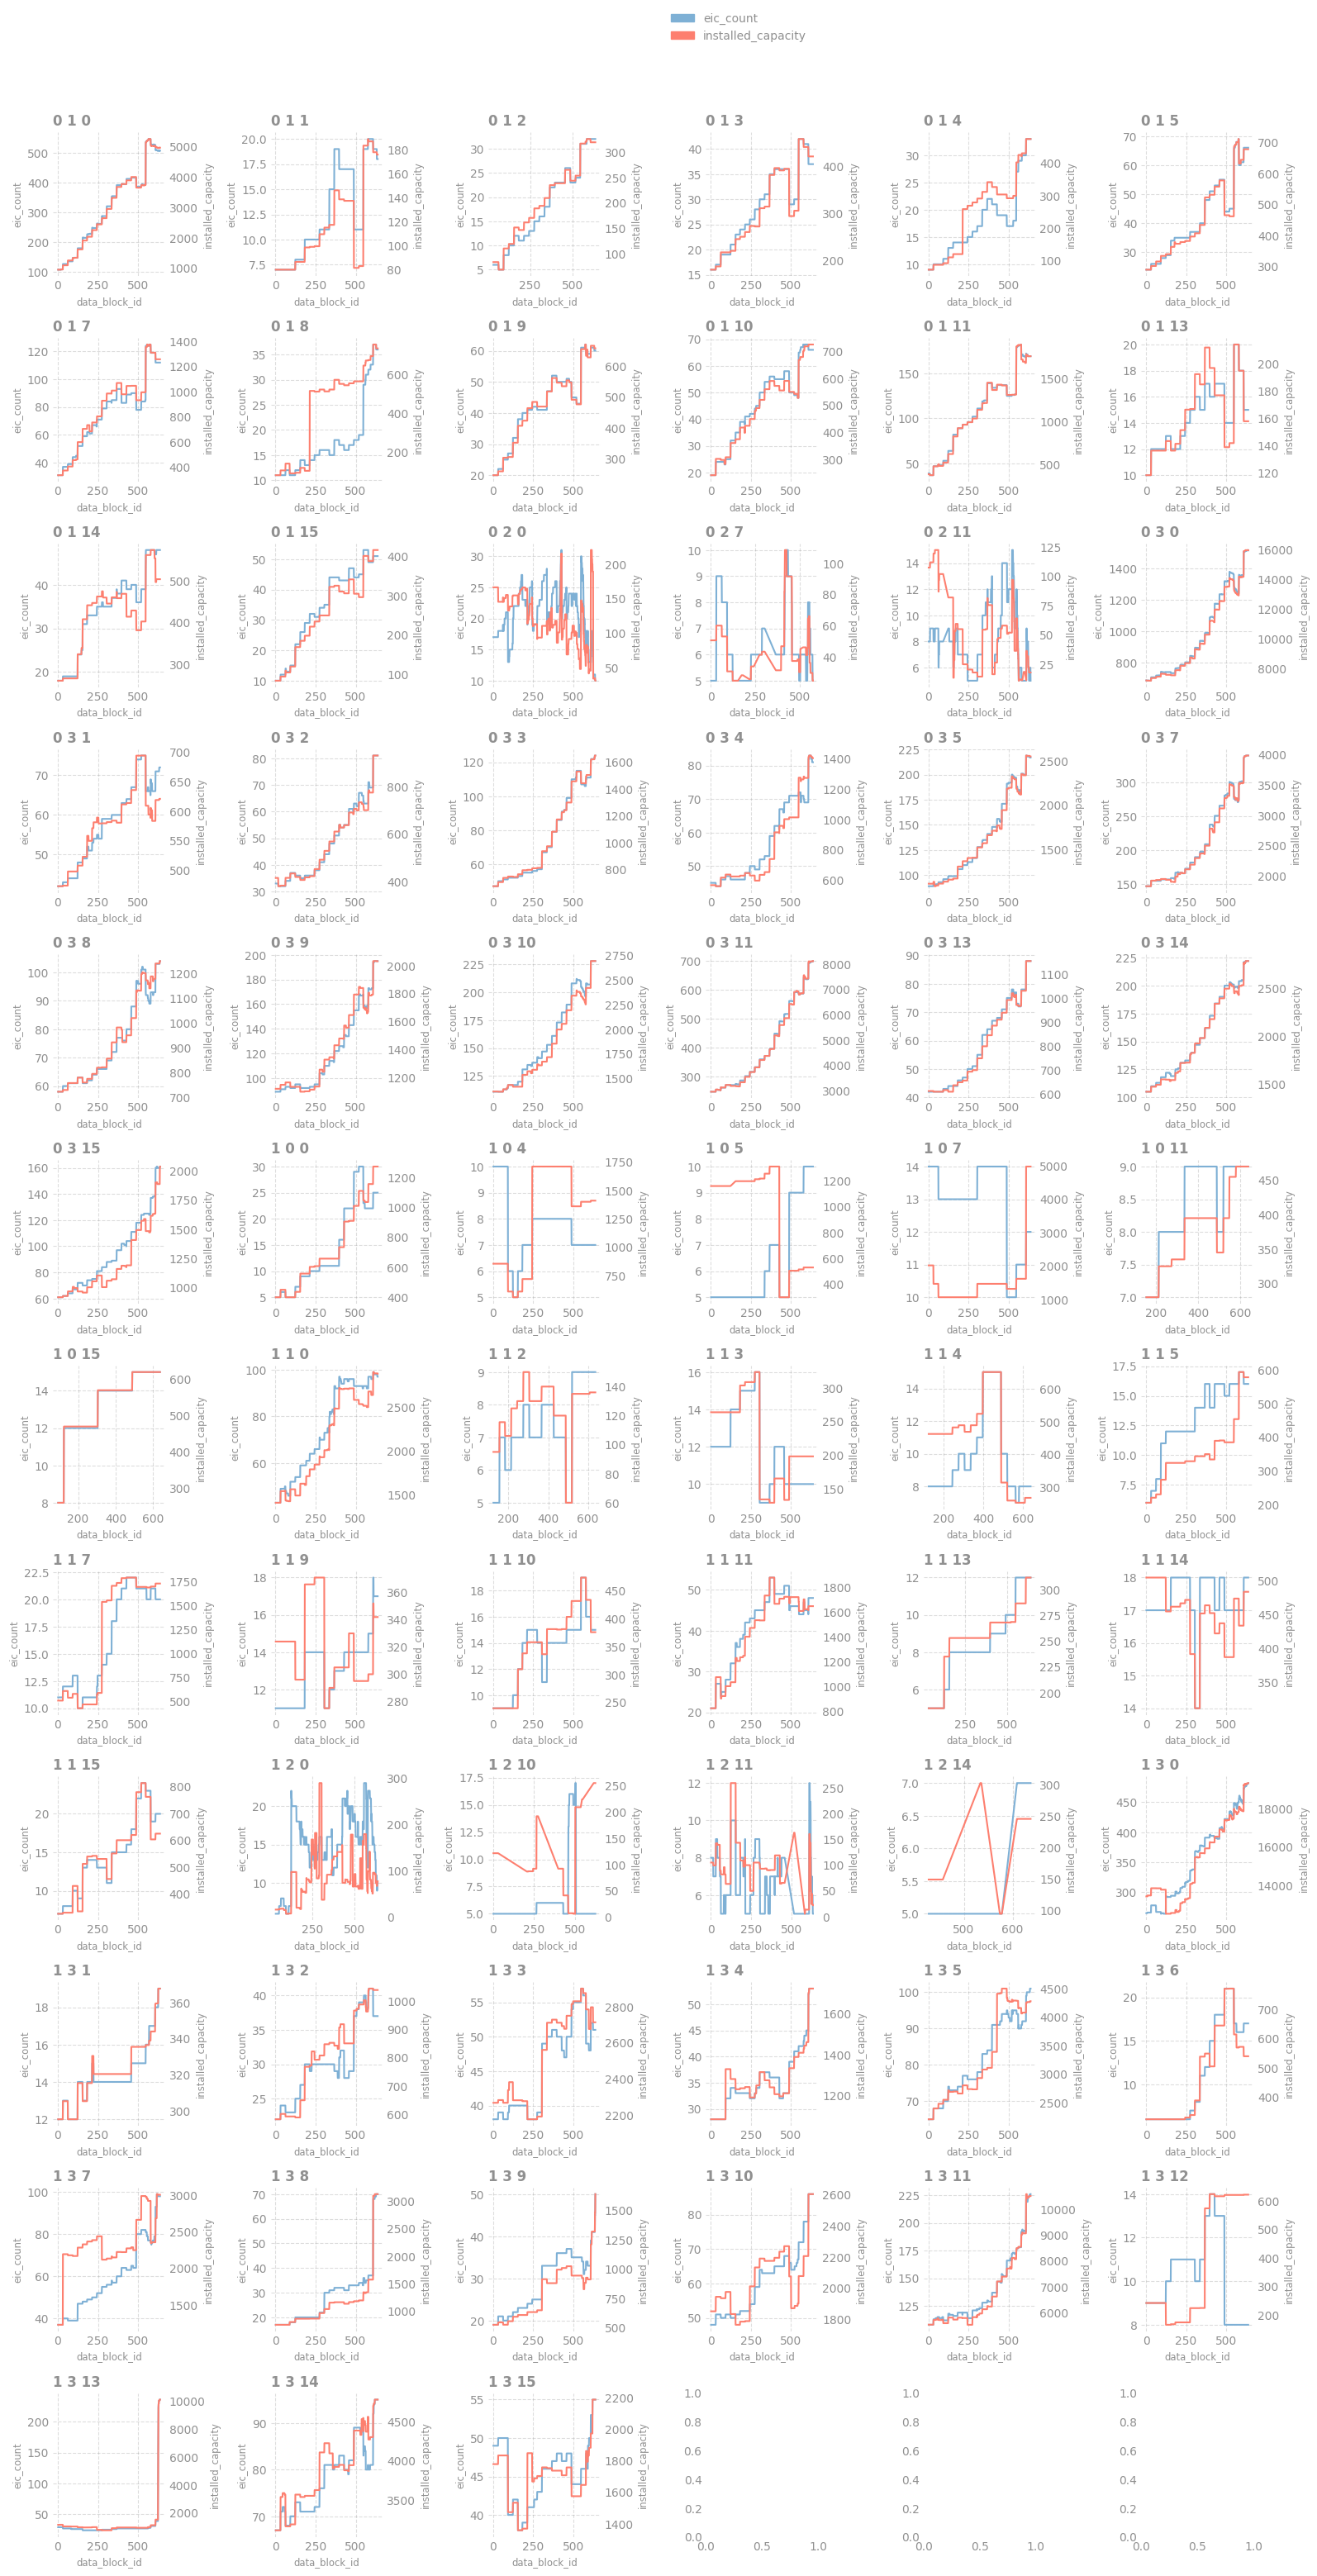

In [4]:
fig, axes = plt.subplots(nrows=72 // 6, ncols=6, figsize=(16, 30))
axes= axes.ravel()

nn = 0
for business in [0, 1]:
    for product in [0, 1, 2, 3]:
        for county in range(16):
            df = df_client.query(f'(is_business == {business}) & (product_type == {product}) & (county == {county})') \
                          .set_index('data_block_id')
            if df.shape[0] > 0:
                sns.lineplot(x=df.index, y=df['eic_count'], ax=axes[nn], color=PALETTE[0])
                sns.lineplot(x=df.index, y=df['installed_capacity'], ax=axes[nn].twinx(), color=PALETTE[1])
                axes[nn].grid(True)
                axes[nn].set_title(f'{business} {product} {county}', fontsize=12)
                nn+=1

import matplotlib.patches as mpatches
eic_patch = mpatches.Patch(color=PALETTE[0], label='eic_count')
cap_patch = mpatches.Patch(color=PALETTE[1], label='installed_capacity')
fig.legend(handles=[eic_patch, cap_patch], bbox_to_anchor=(0.5, 1.02, 0.5, .102), loc='lower left')
plt.tight_layout()
plt.show()

# Electricity prices

In [5]:
df_electricity_prices = pd.read_csv('data/electricity_prices.csv')
df_electricity_prices

,forecast_date,euros_per_mwh,origin_date,data_block_id
0,2021-09-01 00:00:00,92.51,2021-08-31 00:00:00,1
1,2021-09-01 01:00:00,88.90,2021-08-31 01:00:00,1
2,2021-09-01 02:00:00,87.35,2021-08-31 02:00:00,1
3,2021-09-01 03:00:00,86.88,2021-08-31 03:00:00,1
4,2021-09-01 04:00:00,88.43,2021-08-31 04:00:00,1
...,...,...,...,...
15281,2023-05-30 19:00:00,82.10,2023-05-29 19:00:00,637
15282,2023-05-30 20:00:00,150.85,2023-05-29 20:00:00,637
15283,2023-05-30 21:00:00,82.10,2023-05-29 21:00:00,637
15284,2023-05-30 22:00:00,82.09,2023-05-29 22:00:00,637


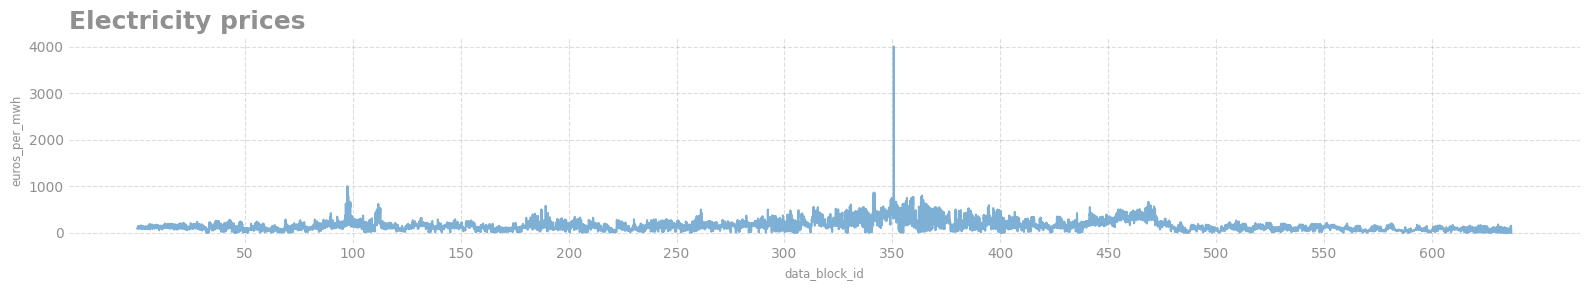

In [6]:
_, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 3))

sns.lineplot(x=df_electricity_prices.index, y=df_electricity_prices['euros_per_mwh'], ax=ax)
ax.set_title('Electricity prices')
ax.set_xticks(24*df_electricity_prices['data_block_id'].unique()[49::50], df_electricity_prices['data_block_id'].unique()[49::50])
ax.set_xlabel('data_block_id')
ax.grid(True)

plt.tight_layout()
plt.savefig(f'electricity prices.png')
plt.show()

In [7]:
df_electricity_prices.loc[df_electricity_prices['euros_per_mwh'] > 1100]

,forecast_date,euros_per_mwh,origin_date,data_block_id
8416,2022-08-17 17:00:00,4000.0,2022-08-16 17:00:00,351


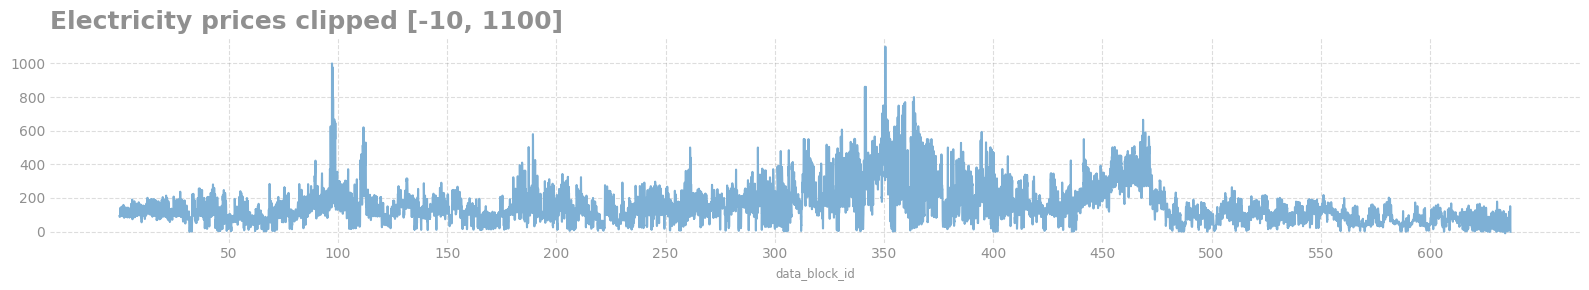

In [8]:
_, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 3))

sns.lineplot(x=df_electricity_prices.index, y=df_electricity_prices['euros_per_mwh'].values.clip(-100, 1100), ax=ax)
ax.set_title('Electricity prices clipped [-10, 1100]')
ax.set_xticks(24*df_electricity_prices['data_block_id'].unique()[49::50], df_electricity_prices['data_block_id'].unique()[49::50])
ax.set_xlabel('data_block_id')
ax.grid(True)

plt.tight_layout()
plt.savefig(f'electricity prices without outlier.png')
plt.show()

# Gas prices

In [9]:
df_gas_prices = pd.read_csv('data/gas_prices.csv')
df_gas_prices

,forecast_date,lowest_price_per_mwh,highest_price_per_mwh,origin_date,data_block_id
0,2021-09-01,45.23,46.32,2021-08-31,1
1,2021-09-02,45.62,46.29,2021-09-01,2
2,2021-09-03,45.85,46.40,2021-09-02,3
3,2021-09-04,46.30,46.80,2021-09-03,4
4,2021-09-05,46.30,46.58,2021-09-04,5
...,...,...,...,...,...
632,2023-05-26,29.10,34.10,2023-05-25,633
633,2023-05-27,28.30,34.10,2023-05-26,634
634,2023-05-28,28.10,34.10,2023-05-27,635
635,2023-05-29,28.16,36.98,2023-05-28,636


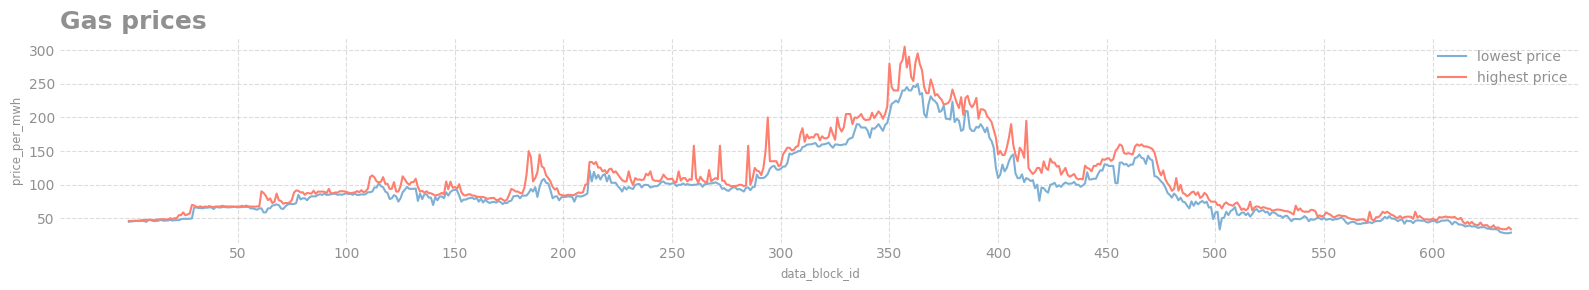

In [10]:
_, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 3))

sns.lineplot(x=df_gas_prices.index, y=df_gas_prices['lowest_price_per_mwh'], ax=ax, label='lowest price')
sns.lineplot(x=df_gas_prices.index, y=df_gas_prices['highest_price_per_mwh'], ax=ax, label='highest price')
ax.set_title('Gas prices')
ax.set_xticks(df_gas_prices['data_block_id'].unique()[49::50], df_gas_prices['data_block_id'].unique()[49::50])
ax.set_xlabel('data_block_id')
ax.set_ylabel('price_per_mwh')
ax.grid(True)

plt.tight_layout()
plt.savefig(f'gas prices.png')
plt.show()

# Weather

In [11]:
df_forecast_weather = pd.read_csv('data/forecast_weather.csv')
df_forecast_weather

,latitude,longitude,origin_datetime,hours_ahead,temperature,dewpoint,cloudcover_high,cloudcover_low,cloudcover_mid,cloudcover_total,10_metre_u_wind_component,10_metre_v_wind_component,data_block_id,forecast_datetime,direct_solar_radiation,surface_solar_radiation_downwards,snowfall,total_precipitation
0,57.6,21.7,2021-09-01 02:00:00,1,15.655786,11.553613,0.904816,0.019714,0.000000,0.905899,-0.411328,-9.106137,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0
1,57.6,22.2,2021-09-01 02:00:00,1,13.003931,10.689844,0.886322,0.004456,0.000000,0.886658,0.206347,-5.355405,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0
2,57.6,22.7,2021-09-01 02:00:00,1,14.206567,11.671777,0.729034,0.005615,0.000000,0.730499,1.451587,-7.417905,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0
3,57.6,23.2,2021-09-01 02:00:00,1,14.844507,12.264917,0.336304,0.074341,0.000626,0.385468,1.090869,-9.163999,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0
4,57.6,23.7,2021-09-01 02:00:00,1,15.293848,12.458887,0.102875,0.088074,0.000015,0.176590,1.268481,-8.975766,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3424507,59.7,26.2,2023-05-30 02:00:00,48,10.150049,5.662744,0.061066,0.257339,0.004059,0.308594,6.890626,-3.258144,637,2023-06-01 02:00:00,0.0,0.0,0.0,0.0
3424508,59.7,26.7,2023-05-30 02:00:00,48,10.259790,5.922754,0.107880,0.895203,0.198700,0.906036,6.890626,-3.768032,637,2023-06-01 02:00:00,0.0,0.0,0.0,0.0
3424509,59.7,27.2,2023-05-30 02:00:00,48,10.467798,6.072534,0.000000,0.387466,0.448853,0.530518,6.214112,-4.700405,637,2023-06-01 02:00:00,0.0,0.0,0.0,0.0
3424510,59.7,27.7,2023-05-30 02:00:00,48,10.694116,7.009058,0.000000,0.505936,0.997314,0.997498,5.810060,-4.338345,637,2023-06-01 02:00:00,0.0,0.0,0.0,0.0


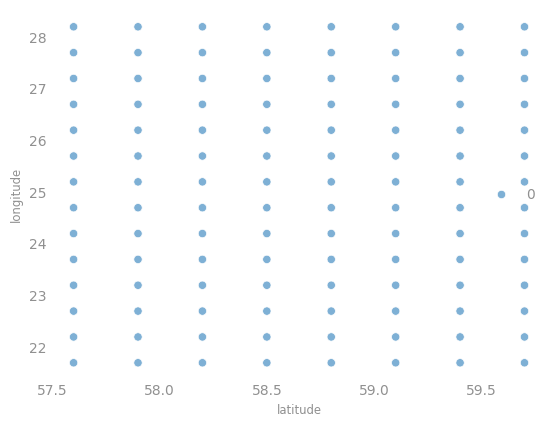

In [12]:
df_coord = df_forecast_weather[['latitude', 'longitude']].drop_duplicates()
sns.scatterplot(x=df_coord['latitude'], 
                y=df_coord['longitude'], 
                hue=0);

In [13]:
df_historical_weather = pd.read_csv('data/historical_weather.csv')
df_historical_weather

,datetime,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,latitude,longitude,data_block_id
0,2021-09-01 00:00:00,14.2,11.6,0.0,0.0,1015.9,31,31,0,11,7.083333,8,0.0,0.0,0.0,57.6,21.7,1.0
1,2021-09-01 00:00:00,13.9,11.5,0.0,0.0,1010.7,33,37,0,0,5.111111,359,0.0,0.0,0.0,57.6,22.2,1.0
2,2021-09-01 00:00:00,14.0,12.5,0.0,0.0,1015.0,31,34,0,0,6.333333,355,0.0,0.0,0.0,57.6,22.7,1.0
3,2021-09-01 00:00:00,14.6,11.5,0.0,0.0,1017.3,0,0,0,0,8.083333,297,358.0,277.0,81.0,57.6,23.2,1.0
4,2021-09-01 00:00:00,15.7,12.9,0.0,0.0,1014.0,22,25,0,0,8.416667,5,0.0,0.0,0.0,57.6,23.7,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1710797,2023-05-30 10:00:00,11.7,4.6,0.0,0.0,1018.9,40,9,54,0,1.055556,253,567.0,392.0,175.0,59.7,26.2,637.0
1710798,2023-05-30 10:00:00,12.3,3.5,0.0,0.0,1019.0,46,4,70,0,0.805556,263,581.0,407.0,174.0,59.7,26.7,637.0
1710799,2023-05-30 10:00:00,9.8,3.0,0.0,0.0,1019.2,41,4,62,0,1.972222,285,609.0,432.0,177.0,59.7,27.2,637.0
1710800,2023-05-30 10:00:00,11.7,1.6,0.0,0.0,1019.0,44,0,73,0,3.500000,307,658.0,521.0,137.0,59.7,27.7,637.0


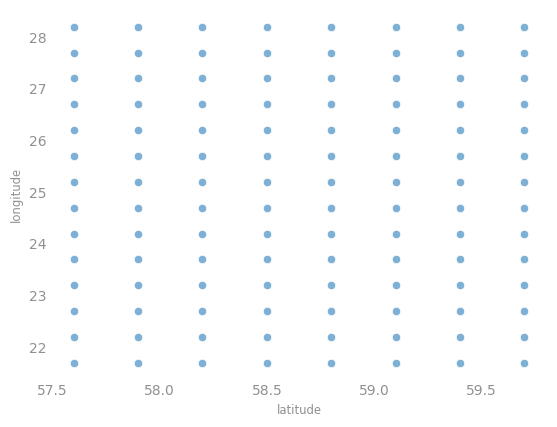

In [16]:
df_coord = df_historical_weather[['latitude', 'longitude']].drop_duplicates()
sns.scatterplot(x=df_coord['latitude'], 
                y=df_coord['longitude']);

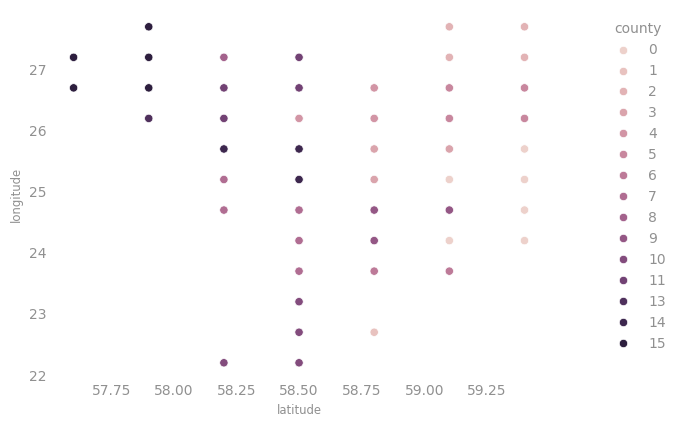

In [15]:
df_weather_station_to_county_mapping = pd.read_csv('data/weather_station_to_county_mapping.csv').dropna()
sc = sns.scatterplot(x=df_weather_station_to_county_mapping['latitude'], 
                y=df_weather_station_to_county_mapping['longitude'], 
                hue=(df_weather_station_to_county_mapping['county']).astype(int),
                legend='full')
sns.move_legend(sc, loc="upper left", bbox_to_anchor=(1.1, 1))